# Imports
1. Essentials
2. Time Series specific
3. Others



In [1]:
!pip install numpy==1.24.4 pmdarima==2.0.4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [5]:
ticker = 'SPY'  # S&P 500
start_date = '2018-01-01'
end_date = '2024-12-31'

In [6]:
data = yf.download(ticker, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2018-01-02,238.568741,238.604254,237.352690,237.743250,86655700
2018-01-03,240.077682,240.228592,238.737350,238.737350,90070400
2018-01-04,241.089539,241.577752,240.139794,240.725634,80636400
2018-01-05,242.696213,242.820467,241.391393,241.888465,83524000
2018-01-08,243.140015,243.299782,242.305639,242.598545,57319200


In [7]:
data.columns = data.columns.droplevel(1)
data.reset_index(inplace=True)
data=data[['Date','Close','High','Low','Open','Volume']]
data.head()

Price,Date,Close,High,Low,Open,Volume
0,2018-01-02,238.568741,238.604254,237.352690,237.743250,86655700
1,2018-01-03,240.077682,240.228592,238.737350,238.737350,90070400
2,2018-01-04,241.089539,241.577752,240.139794,240.725634,80636400
3,2018-01-05,242.696213,242.820467,241.391393,241.888465,83524000
4,2018-01-08,243.140015,243.299782,242.305639,242.598545,57319200


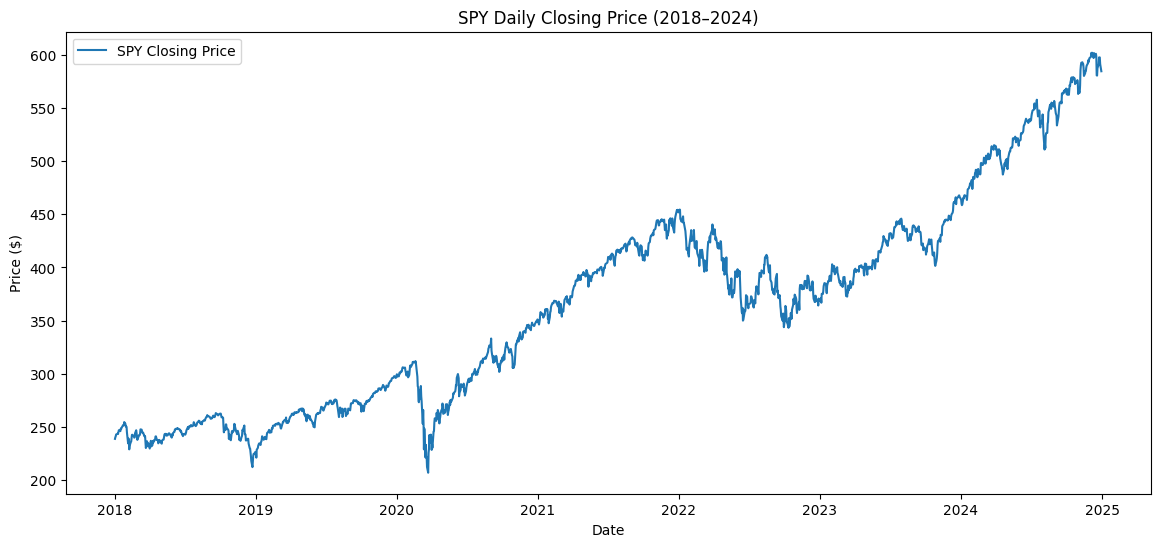

In [8]:
ts = data[['Date', 'Close']].copy()
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(ts['Close'], label='SPY Closing Price')
plt.title('SPY Daily Closing Price (2018–2024)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [9]:
print(f"Missing values: {ts.isnull().sum()}")
ts.dropna(inplace=True)

Missing values: Price
Close    0
dtype: int64


# Augmented Dickey Fuller Test

In [10]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')

    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")

adf_test(ts, 'Original Series')

Augmented Dickey-Fuller Test: Original Series
ADF Test Statistic : 0.31735426537539313
p-value : 0.9781268290921652
# Lags Used : 10
Number of Observations Used : 1749
=> Non-stationary (fail to reject H0)


# Differencing for Stationarity

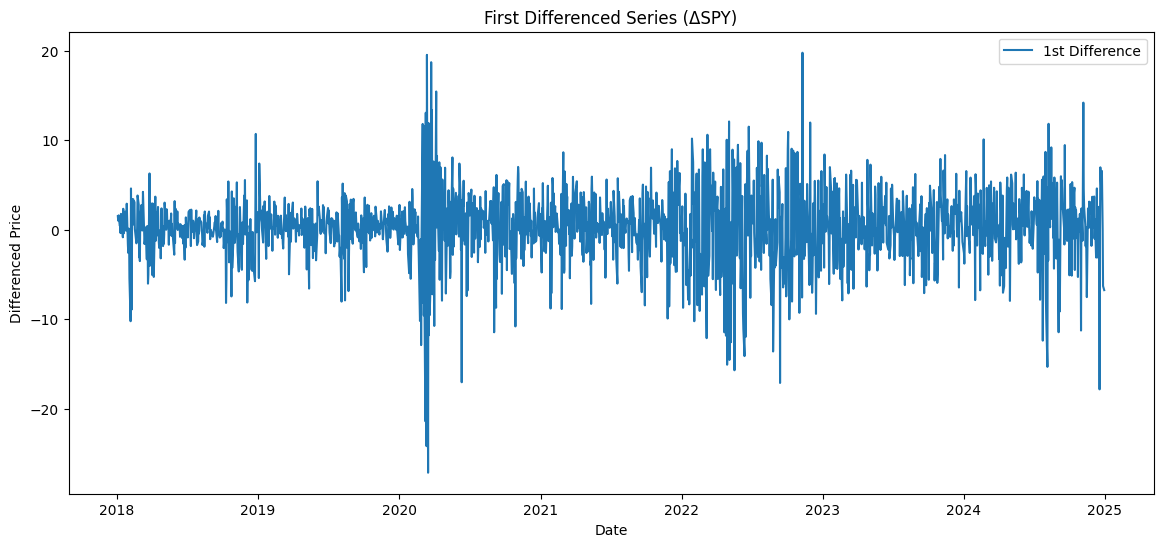

Augmented Dickey-Fuller Test: First Difference
ADF Test Statistic : -13.265601118335134
p-value : 8.230767001879085e-25
# Lags Used : 9
Number of Observations Used : 1749
=> Stationary (reject H0)


In [11]:
# First-order differencing
ts_diff = ts.diff().dropna()

plt.figure(figsize=(14, 6))
plt.plot(ts_diff, label='1st Difference')
plt.title('First Differenced Series (ΔSPY)')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

adf_test(ts_diff, 'First Difference')

# ACF and PACF Plots

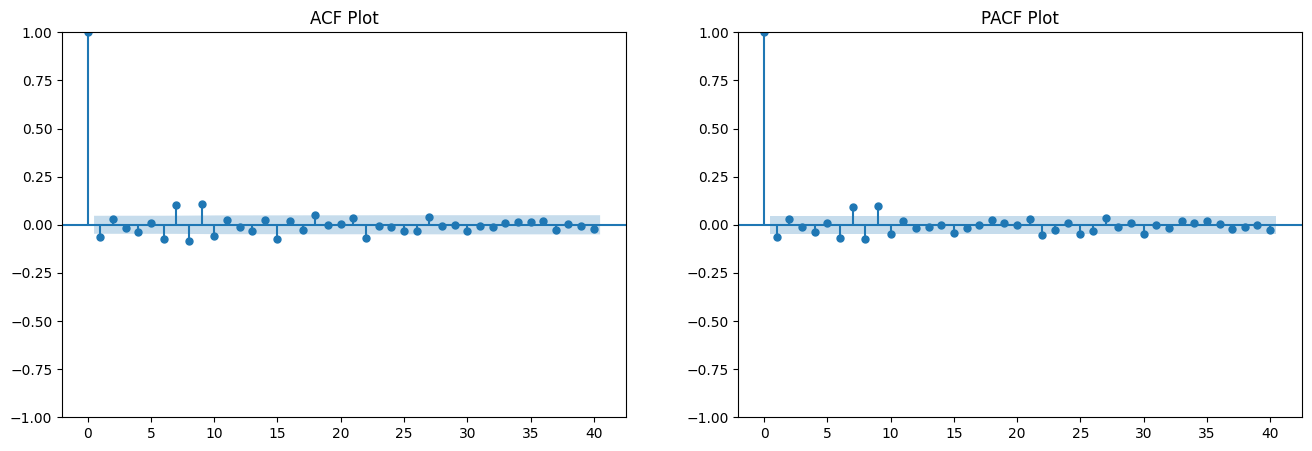

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(ts_diff, ax=axes[0], lags=40)
plot_pacf(ts_diff, ax=axes[1], lags=40)
axes[0].set_title('ACF Plot')
axes[1].set_title('PACF Plot')
plt.show()

In [13]:
# Auto ARIMA finds optimal (p,d,q)
stepwise_model = auto_arima(ts, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9932.785, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9934.330, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9929.620, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9929.986, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9936.437, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9930.244, Time=0.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9930.481, Time=1.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9932.163, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9932.264, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 7.369 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1760
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4961.810
Date:                Wed, 30 Jul 2025   AIC                           9929.620
Time:                        07:19:49   BIC                           9946.038
Sample:                             0   HQIC                          9935.688
                               - 1760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2089      0.101      2.077      0.038       0.012       0.406
ar.L1         -0.0617      0.015     -4.255      0.000      -0.090      -0.033
sigma2        16.5060      0.333     49.635      0.000      15.854      17.158
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1400.10
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Train Test Split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

print(f"Training data from {train.index[0]} to {train.index[-1]}")
print(f"Testing data from {test.index[0]} to {test.index[-1]}")

Training data from 2018-01-02 00:00:00 to 2023-08-07 00:00:00
Testing data from 2023-08-08 00:00:00 to 2024-12-30 00:00:00


# Fitting ARIMA Model

In [83]:
model = ARIMA(train, order=(1,1,0))
fitted_model = model.fit()

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1408
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3973.698
Date:                Wed, 30 Jul 2025   AIC                           7951.396
Time:                        09:05:04   BIC                           7961.895
Sample:                             0   HQIC                          7955.320
                               - 1408                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0895      0.015     -5.795      0.000      -0.120      -0.059
sigma2        16.6196      0.356     46.731      0.000      15.923      17.317
Ljung-Box (L1) (Q):                   0.00   Jarque-

# Model Diagnostics

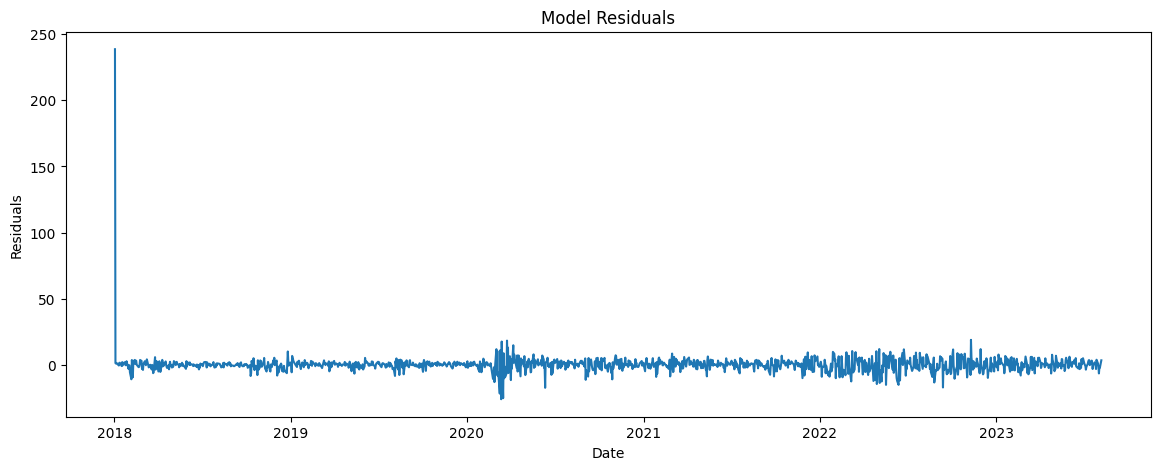

In [78]:
residuals = fitted_model.resid

plt.figure(figsize=(14, 5))
plt.plot(residuals)
plt.title('Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

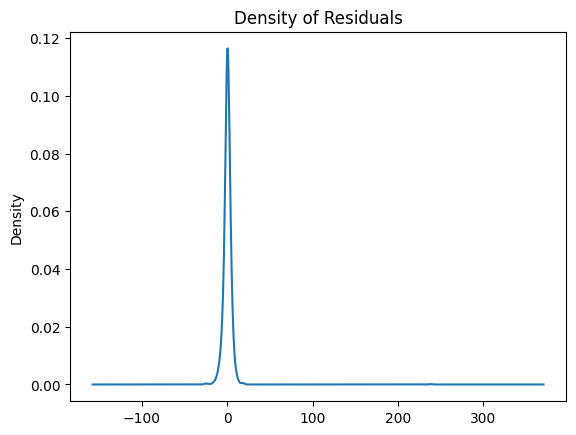

In [79]:
# Histogram of residuals
residuals.plot(kind='kde', title='Density of Residuals')
plt.show()

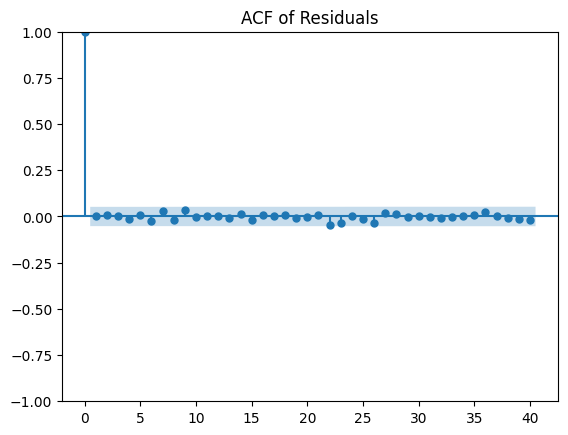

In [80]:
# ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Forecasting on Test Data


In [81]:
forecast = fitted_model.forecast(steps=len(test))
forecast

,predicted_mean
1408,438.638424
1409,438.771052
1410,438.725495
1411,438.741143
1412,438.735768
...,...
1755,438.737142
1756,438.737142
1757,438.737142
1758,438.737142


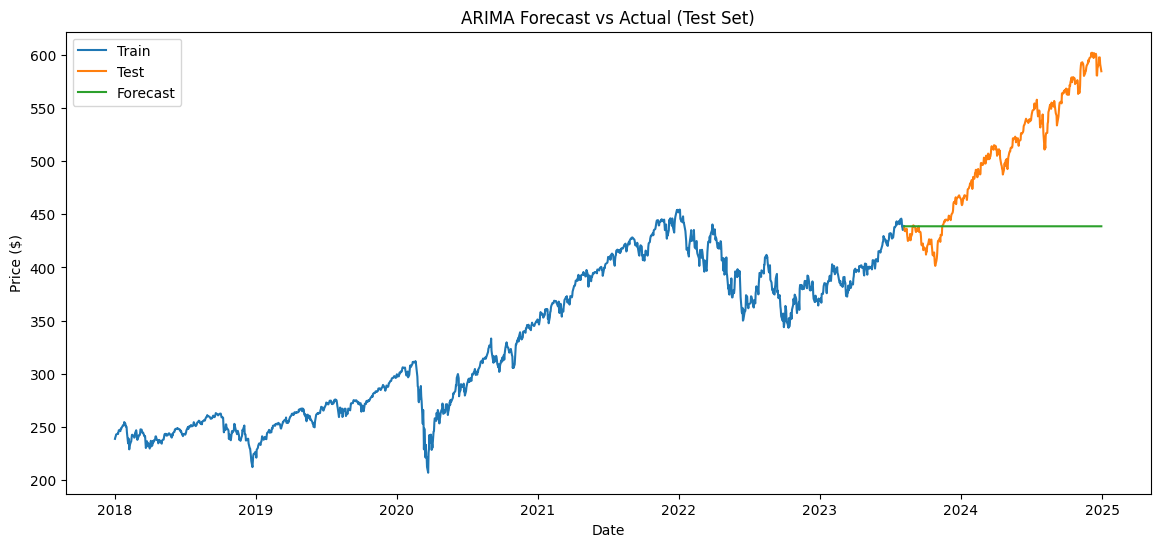

In [82]:
# Plot forecast vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('ARIMA Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE:  71.88
MSE:  7588.93
RMSE: 87.11


## The model Performs very poorly, We will Use log returns instead of raw prices now

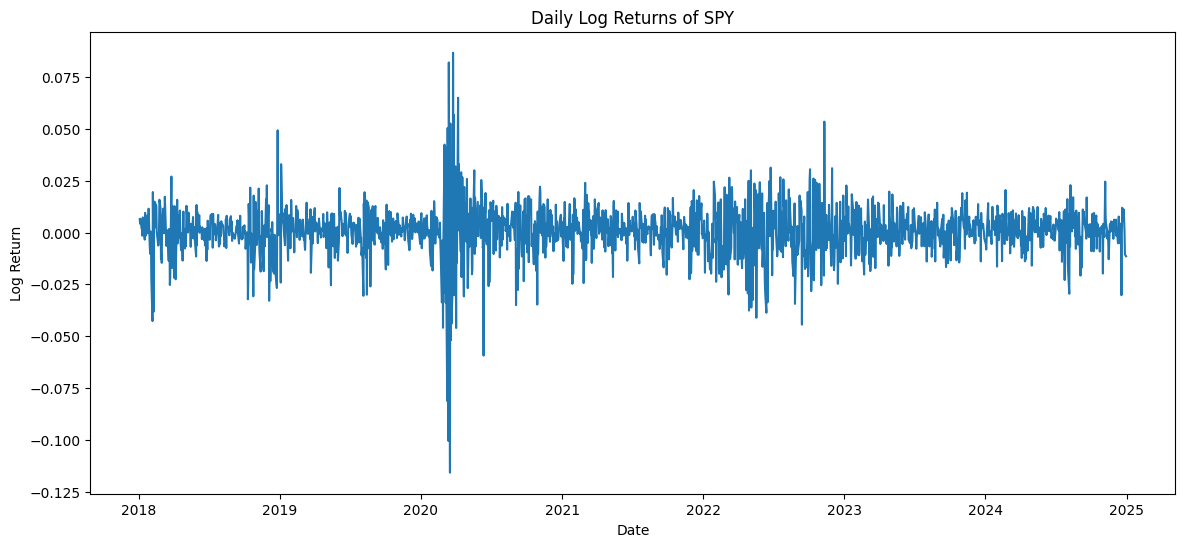

In [27]:
log_returns = np.log(ts / ts.shift(1)).dropna()

plt.figure(figsize=(14,6))
plt.plot(log_returns)
plt.title('Daily Log Returns of SPY')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

In [28]:
train_r = log_returns[:train_size]
test_r = log_returns[train_size:]

print(f"Train shape: {train_r.shape}")
print(f"Test shape: {test_r.shape}")


Train shape: (1408, 1)
Test shape: (351, 1)


In [29]:
stepwise_model = auto_arima(log_returns, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-10508.384, Time=3.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10474.304, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10503.094, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10498.690, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10507.106, Time=1.56 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10507.842, Time=0.82 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-10506.211, Time=2.56 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10507.927, Time=1.80 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10505.228, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10507.477, Time=0.86 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-10506.233, Time=0.57 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10504.432, Time=3.86 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10507.357, Time=1.19 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 18.009 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1759
Model:               SARIMAX(2, 0, 2)   Log Likelihood                5259.192
Date:                Wed, 30 Jul 2025   AIC                         -10508.384
Time:                        07:57:14   BIC                         -10481.021
Sample:                             0   HQIC                        -10498.271
                               - 1759                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4330      0.287     -1.508      0.132      -0.996       0.130
ar.L2         -0.1847      0.155     -1.188      0.235      -0.489       0.120
ma.L1          0.3099      0.288      1.074      0.283      -0.255       0.875
ma.L2          0.2235      0.123      1.814      0.070      -0.018       0.465
sigma2         0.0001   2.11e-06     70.136      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8865.23
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model = ARIMA(train_r, order=(2,0,2))
fitted_r = model.fit()

print(fitted_r.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1408
Model:                 ARIMA(2, 0, 2)   Log Likelihood                4116.889
Date:                Wed, 30 Jul 2025   AIC                          -8221.777
Time:                        07:57:36   BIC                          -8190.278
Sample:                             0   HQIC                         -8210.005
                               - 1408                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.185      0.236      -0.000       0.001
ar.L1         -0.4957      0.647     -0.766      0.444      -1.765       0.773
ar.L2         -0.0712      0.346     -0.206      0.8

In [60]:
forecast_s = fitted_r.simulate(nsimulations=len(test_r))

In [69]:
last_train_price = ts.iloc[train_size - 1]
last_train_price

,2023-08-07
Price,
Close,439.024536


In [63]:
cum_returns=np.cumsum(forecast_s.values)

In [70]:
last_train_price = last_train_price.iloc[0]
last_train_price

439.0245361328125

In [66]:
forecast_prices =last_train_price * np.exp(cum_returns)

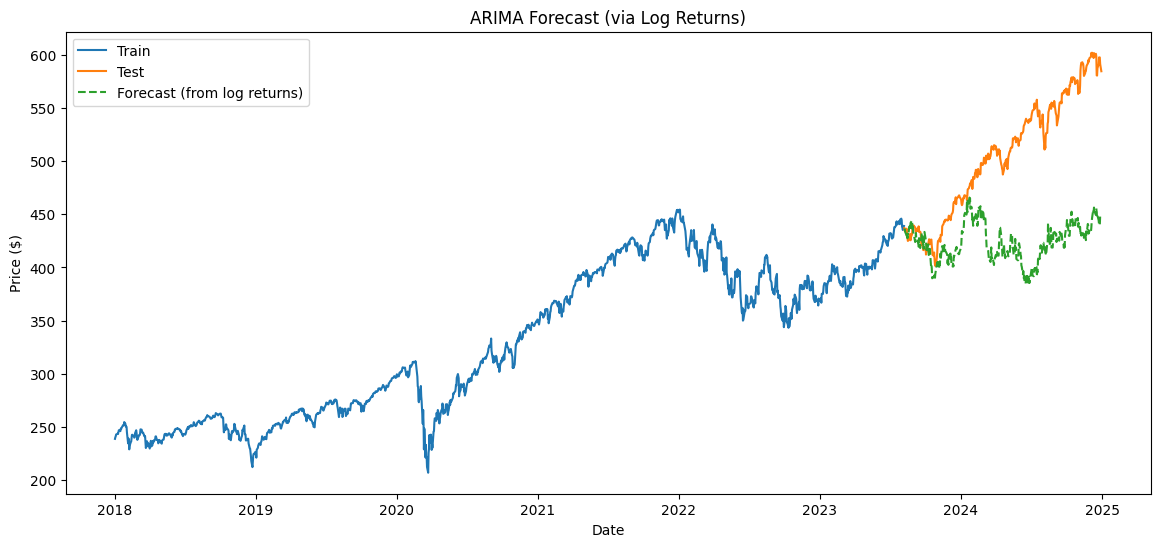

In [67]:
# Plot comparison
plt.figure(figsize=(14,6))
plt.plot(ts.index[:train_size], ts[:train_size], label='Train')
plt.plot(ts.index[train_size:], ts[train_size:], label='Test')
forecast_index = ts.index[train_size+1:]
plt.plot(forecast_index, forecast_prices, label='Forecast (from log returns)', linestyle='--')
plt.title('ARIMA Forecast (via Log Returns)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [73]:
actual = ts[train_size+1:]
mse = mean_squared_error(actual, forecast_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_prices)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE:  82.49
MSE:  9670.30
RMSE: 98.34


# Stochastic price forecast

In [74]:
forecast_obj=fitted_r.get_forecast(steps=len(test_r))
mean = forecast_obj.predicted_mean
std = forecast_obj.se_mean

# Simulate paths
simulated_returns = np.random.normal(loc=mean, scale=std)
forecast_prices = last_train_price * np.exp(np.cumsum(simulated_returns))


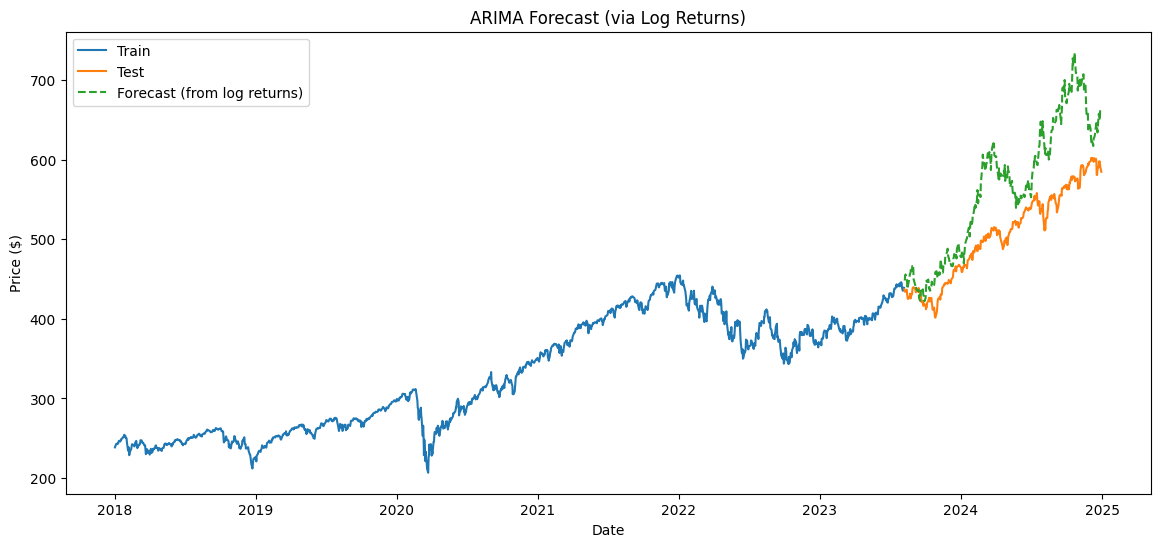

In [75]:
# Plot comparison
plt.figure(figsize=(14,6))
plt.plot(ts.index[:train_size], ts[:train_size], label='Train')
plt.plot(ts.index[train_size:], ts[train_size:], label='Test')
forecast_index = ts.index[train_size+1:]
plt.plot(forecast_index, forecast_prices, label='Forecast (from log returns)', linestyle='--')
plt.title('ARIMA Forecast (via Log Returns)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [76]:
actual = ts[train_size+1:]
mse = mean_squared_error(actual, forecast_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_prices)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE:  58.69
MSE:  4941.34
RMSE: 70.29
